In [1]:
import sqlite3

# Create a SQL connection to our SQLite database
con = sqlite3.connect("../Databases/lastfm_tags.db")

cur = con.cursor()

# The result of a "cursor.execute" can be iterated over by row
for row in cur.execute('SELECT * FROM sqlite_master WHERE type="table";'):
    print(row)

cur.execute('SELECT * FROM sqlite_master WHERE type="table";').fetchall()

('table', 'tags', 'tags', 2, 'CREATE TABLE tags (tag TEXT)')
('table', 'tids', 'tids', 3, 'CREATE TABLE tids (tid TEXT)')
('table', 'tid_tag', 'tid_tag', 4, 'CREATE TABLE tid_tag (tid INT, tag INT, val FLOAT)')


[('table', 'tags', 'tags', 2, 'CREATE TABLE tags (tag TEXT)'),
 ('table', 'tids', 'tids', 3, 'CREATE TABLE tids (tid TEXT)'),
 ('table',
  'tid_tag',
  'tid_tag',
  4,
  'CREATE TABLE tid_tag (tid INT, tag INT, val FLOAT)')]

In [20]:
# len(cur.execute('SELECT * FROM tids;').fetchall())

505216

In [2]:
cur.execute('SELECT * FROM tags LIMIT 5;').fetchall()

[('classic rock',),
 ('Progressive rock',),
 ('blues',),
 ('memphis slim',),
 ('pop',)]

In [3]:
cur.execute('SELECT * FROM tids LIMIT 5;').fetchall()

[('TRCCCYE12903CFF0E9',),
 ('TRCCCFH12903CEBC70',),
 ('TRCCCJT128F429FFF6',),
 ('TRCCCBJ128F4286E6F',),
 ('TRCCJTI128EF35394A',)]

In [4]:
cur.execute('SELECT * FROM tid_tag LIMIT 5;').fetchall()

[(1, 1, 100.0), (1, 2, 100.0), (2, 3, 100.0), (2, 4, 100.0), (3, 5, 100.0)]

In [6]:
import pandas as pd

In [7]:
tid_df = pd.read_sql_query("SELECT * FROM tids;", con)

In [8]:
tag_df = pd.read_sql_query("SELECT * FROM tags;", con)

In [9]:
tid_tag_df = pd.read_sql_query("SELECT * FROM tid_tag;", con)

In [10]:
tid_df.head()

,tid
0,TRCCCYE12903CFF0E9
1,TRCCCFH12903CEBC70
2,TRCCCJT128F429FFF6
3,TRCCCBJ128F4286E6F
4,TRCCJTI128EF35394A


In [11]:
tag_df.head()

,tag
0,classic rock
1,Progressive rock
2,blues
3,memphis slim
4,pop


In [12]:
tid_tag_df.head()

,tid,tag,val
0,1,1,100.0
1,1,2,100.0
2,2,3,100.0
3,2,4,100.0
4,3,5,100.0


In [16]:
map_idx_tid = {}
for i in range(len(tid_df)):
    map_idx_tid[i + 1] = tid_df['tid'][i]

In [17]:
map_idx_tag = {}
for i in range(len(tag_df)):
    map_idx_tag[i + 1] = tag_df['tag'][i]

In [18]:
tid_tag_df['tid'] = tid_tag_df['tid'].apply(lambda x: map_idx_tid[x])

In [19]:
tid_tag_df['tag'] = tid_tag_df['tag'].apply(lambda x: map_idx_tag[x])

In [20]:
tid_tag_df.head()

,tid,tag,val
0,TRCCCYE12903CFF0E9,classic rock,100.0
1,TRCCCYE12903CFF0E9,Progressive rock,100.0
2,TRCCCFH12903CEBC70,blues,100.0
3,TRCCCFH12903CEBC70,memphis slim,100.0
4,TRCCCJT128F429FFF6,pop,100.0


In [21]:
len(tid_tag_df)

8598630

In [45]:
import numpy as np
tid_tag_df['tag'].value_counts() == 1000

rock                               False
pop                                False
alternative                        False
indie                              False
electronic                         False
                                   ...  
but best MCR song ever recorded    False
musique noir                       False
Caruso Il divo                     False
good pop punk song                 False
whats in it for me                 False
Name: tag, Length: 522366, dtype: bool

In [37]:
tid_tag_count_df = pd.DataFrame(tid_tag_df['tag'].value_counts())
tid_tag_count_df.head()

,tag
rock,101071
pop,69159
alternative,55777
indie,48175
electronic,46270


In [54]:
sum(tid_tag_count_df['tag'][:1000]),sum(tid_tag_count_df['tag'][1000:])

(3826907, 4771723)

In [70]:
sum(tid_tag_count_df['tag'][:10])/ sum(tid_tag_count_df['tag'])

0.05848478187804336

In [49]:
tid_tag_count_df[:500]

,tag
rock,101071
pop,69159
alternative,55777
indie,48175
electronic,46270
...,...
Classic Blues,1613
Solomusika-Loved,1612
san francisco,1607
addictive,1605


In [ ]:
tid_tag_

In [63]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sparse_dot_topn import awesome_cossim_topn

# Import your data to a Pandas.DataFrame
df = tid_tag_df

# Instaniate our lookup hash table
group_lookup = {}


# Write a function for cleaning strings and returning an array of ngrams
def ngrams_analyzer(string):
    string = re.sub(r'[,-./]', r'', string)
    ngrams = zip(*[string[i:] for i in range(3)])  # N-Gram length is 5
    return [''.join(ngram) for ngram in ngrams]


def find_group(row, col):
    # If either the row or the col string have already been given
    # a group, return that group. Otherwise return none
    if row in group_lookup:
        return group_lookup[row]
    elif col in group_lookup:
        return group_lookup[col]
    else:
        return None


def add_vals_to_lookup(group, row, col):
    # Once we know the group name, set it as the value
    # for both strings in the group_lookup
    group_lookup[row] = group
    group_lookup[col] = group


def add_pair_to_lookup(row, col):
    # in this function we'll add both the row and the col to the lookup
    group = find_group(row, col)  # first, see if one has already been added
    if group is not None:
        # if we already know the group, make sure both row and col are in lookup
        add_vals_to_lookup(group, row, col)
    else:
        # if we get here, we need to add a new group.
        # The name is arbitrary, so just make it the row
        add_vals_to_lookup(row, row, col)


# Construct your vectorizer for building the TF-IDF matrix
vectorizer = TfidfVectorizer(analyzer=ngrams_analyzer)

# Grab the column you'd like to group, filter out duplicate values
# and make sure the values are Unicode
vals = df['tag'].unique().astype('U')

# Build the matrix!!!
tf_idf_matrix = vectorizer.fit_transform(vals)

# cosine_matrix = awesome_cossim_topn(tf_idf_matrix, tf_idf_matrix.transpose(), vals.size, 0.8)
cosine_matrix = awesome_cossim_topn(tf_idf_matrix, tf_idf_matrix.transpose(), 10, 0.8)

# Build a coordinate matrix
coo_matrix = cosine_matrix.tocoo()

# for each row and column in coo_matrix
# if they're not the same string add them to the group lookup
for row, col in zip(coo_matrix.row, coo_matrix.col):
    if row != col:
        add_pair_to_lookup(vals[row], vals[col])

df['Group'] = df['tag'].map(group_lookup).fillna(df['tag'])

In [64]:
df.head()

,tid,tag,val,Group
0,TRCCCYE12903CFF0E9,classic rock,100.0,classick rock
1,TRCCCYE12903CFF0E9,Progressive rock,100.0,progressive trance
2,TRCCCFH12903CEBC70,blues,100.0,blues
3,TRCCCFH12903CEBC70,memphis slim,100.0,memphis slim
4,TRCCCJT128F429FFF6,pop,100.0,pop


In [65]:
len(set(df['Group']))

440844

In [67]:
len(set(df['tag']))

522366

In [59]:
len(set(df['Group']))

1622

In [42]:
pd.DataFrame(tid_tag_df['tag'].value_counts() > 1000)['tag'].value_counts()

False    521537
True        829
Name: tag, dtype: int64

In [35]:
import matplotlib.pyplot as plt

(array([4.57456e+05, 2.52710e+04, 1.10780e+04, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.11070000e+01, 2.12140000e+01, ...,
        1.01050786e+05, 1.01060893e+05, 1.01071000e+05]),
 <BarContainer object of 10000 artists>)

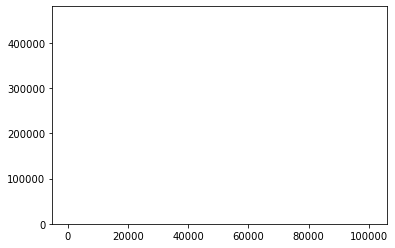

In [40]:
plt.hist(tid_tag_count_df['tag'],bins = 10000)

In [25]:
len(cur.execute('SELECT * FROM tags;').fetchall())

522366

In [18]:
cur.execute('SELECT * FROM tid_tag LIMIT 5;').fetchall()

[(505216,)]

In [ ]:
tid_df = pd.read_sql_query("SELECT * FROM tids;", con)

In [22]:
len(cur.execute('SELECT * FROM tid_tag;').fetchall())

8598630

In [24]:
cur.execute('SELECT COUNT(DISTINCT(tag)) FROM tid_tag LIMIT 5;').fetchall()

[(522366,)]